In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Mounted at /content/drive


In [2]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/XOM.csv')
df1=df.reset_index()['Close']

df1.head()

0    85.029999
1    86.699997
2    86.820000
3    86.750000
4    87.139999
Name: Close, dtype: float64

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# Xem dữ liệu sau chuẩn hóa
df1[:10]

array([[0.61080711],
       [0.62984494],
       [0.63121296],
       [0.63041497],
       [0.63486092],
       [0.63064293],
       [0.62277705],
       [0.63246695],
       [0.63919286],
       [0.63292296]])

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

time_step = 60
train_data = df1[:train_size]
test_data = df1[train_size-time_step:train_size+test_size]
val_data = df1[train_size+test_size-time_step:, :]

print('Độ dài dataframe df1: ', len(df1))
print('Độ dài tập train: ',train_size)
print('Độ dài tập test: ', test_size)
print('Độ dài tập val: ', val_size)

Độ dài dataframe df1:  1337
Độ dài tập train:  935
Độ dài tập test:  267
Độ dài tập val:  135


In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----59   Y=60
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for RNN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
28/28 [==============================] - 3s 37ms/step - loss: 0.0226 - val_loss: 0.0034
Epoch 2/50
28/28 [==============================] - 1s 24ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 3/50
28/28 [==============================] - 1s 19ms/step - loss: 9.6188e-04 - val_loss: 0.0027
Epoch 4/50
28/28 [==============================] - 0s 14ms/step - loss: 8.3152e-04 - val_loss: 0.0023
Epoch 5/50
28/28 [==============================] - 0s 15ms/step - loss: 7.2030e-04 - val_loss: 0.0019
Epoch 6/50
28/28 [==============================] - 0s 15ms/step - loss: 6.6913e-04 - val_loss: 0.0016
Epoch 7/50
28/28 [==============================] - 0s 14ms/step - loss: 6.1746e-04 - val_loss: 0.0019
Epoch 8/50
28/28 [==============================] - 0s 14ms/step - loss: 5.5517e-04 - val_loss: 0.0017
Epoch 9/50
28/28 [==============================] - 0s 14ms/step - loss: 5.1212e-04 - val_loss: 0.0018
Epoch 10/50
28/28 [==============================] - 0s 14ms/step - loss: 5.0152e

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 8ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

# Đưa kết quả về dạng gốc
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val- y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val))
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred))

# In kết quả
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 3.4937967891348705
Testing RMSE: 2.2458536915555527
Validation MAPE: 2.696090418194718
Testing MAPE: 2.133109794356037
Validation MDA: 42.53731343283582
Testing MDA: 52.255639097744364


In [13]:
# 13. Dự báo 30 ngày tiếp theo
# x_input=val_data[60:].reshape(1,-1)

n_days=30
x_input=val_data[-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<n_days):

    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_step,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.93390816]
61
1 day input [0.96397633 0.9494984  0.90857277 0.91735066 0.91518473 0.95155039
 0.94015048 0.94505244 1.         0.98438218 0.96865025 0.9646603
 0.96078437 0.91005473 0.90880073 0.89238491 0.90389877 0.90401279
 0.90173284 0.89443691 0.90560876 0.91142275 0.92749658 0.93889649
 0.91381672 0.89523489 0.8855449  0.87015505 0.85601918 0.86057916
 0.79993165 0.79320566 0.77963973 0.80939351 0.86171914 0.8337893
 0.8203375  0.82170543 0.84758327 0.86263115 0.88360694 0.88964888
 0.89158693 0.96534426 0.95269037 0.9751482  0.95303243 0.94721845
 0.95645235 0.95508441 0.9612403  0.96443234 0.94904239 0.97457825
 0.97036026 0.95975833 0.96397633 0.98894208 0.96979023 0.93390816]
1 day output [[0.9216791]]
2 day input [0.9494984  0.90857277 0.91735066 0.91518473 0.95155039 0.94015048
 0.94505244 1.         0.98438218 0.96865025 0.9646603  0.96078437
 0.91005473 0.90880073 0.89238491 0.90389877 0.90401279 0.90173284
 0.89443691 0.90560876 0.91142275 0.92749658 0.93889649 0.91381

In [14]:
for i in range(1, n_days+1):
    print(f"Ngày thứ {i}: {scaler.inverse_transform(lst_output)[i-1]}")

Ngày thứ 1: [113.37242239]
Ngày thứ 2: [112.29968709]
Ngày thứ 3: [109.91870308]
Ngày thứ 4: [108.2579685]
Ngày thứ 5: [106.76399755]
Ngày thứ 6: [105.15958459]
Ngày thứ 7: [103.40071071]
Ngày thứ 8: [102.48535384]
Ngày thứ 9: [101.24328249]
Ngày thứ 10: [99.91522292]
Ngày thứ 11: [98.9843844]
Ngày thứ 12: [98.12138593]
Ngày thứ 13: [97.27838654]
Ngày thứ 14: [96.54171432]
Ngày thứ 15: [96.06735168]
Ngày thứ 16: [95.50899811]
Ngày thứ 17: [94.9803739]
Ngày thứ 18: [94.59430003]
Ngày thứ 19: [94.34912954]
Ngày thứ 20: [93.91729045]
Ngày thứ 21: [93.38995245]
Ngày thứ 22: [93.29261834]
Ngày thứ 23: [93.05391552]
Ngày thứ 24: [92.82621873]
Ngày thứ 25: [92.6542109]
Ngày thứ 26: [92.42763302]
Ngày thứ 27: [92.13467386]
Ngày thứ 28: [91.84764384]
Ngày thứ 29: [91.56511034]
Ngày thứ 30: [91.27213549]


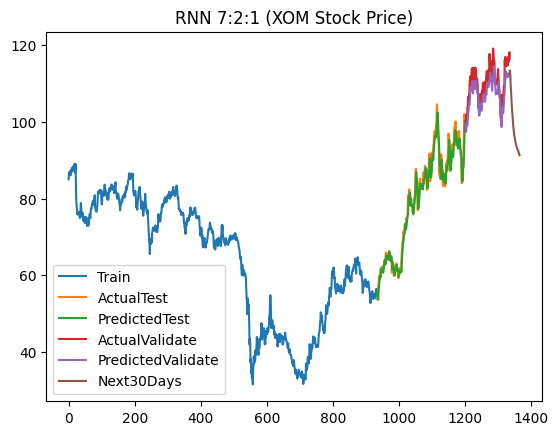

In [15]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+n_days, step=1)

plt.plot(scaler.inverse_transform(train_data))

plt.plot(test_data_index,y_test)
plt.plot(test_data_index,y_pred)

plt.plot(val_data_index,y_val)
plt.plot(val_data_index,y_pred_val)

plt.plot(predict_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate','Next30Days'])
plt.title("RNN 7:2:1 (XOM Stock Price)")
plt.show()

**Plot predict XOM's stock price 30 days in future with dataset ratio 7:2:1**

In [16]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

prediect_index = pd.RangeIndex(start=1, stop=1+n_days, step=1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=prediect_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#FF7F0E'))
for i in range(len(prediect_index)):
  fig.add_annotation(
      x=prediect_index[i],
      y=scaler.inverse_transform(lst_output)[i, 0],
      text=f"{scaler.inverse_transform(lst_output)[i, 0]:.2f}",
      showarrow=False,
      font=dict(color='black'),
      align='center',
      yshift=10)

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'RNN Prediction 7:2:1 (XOM Stock Price)', title_x = 0.5,
                  xaxis_title="Day",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()